# Intel Image Classification (CNN - Keras)

# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']

# Link names with class numbers
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (32, 32)

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['C:/Users/Daney/Desktop/Archivos/Material/Databases/intel_classif/seg_train/seg_train',
                'C:/Users/Daney/Desktop/Archivos/Material/Databases/intel_classif/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder.
            for file in os.listdir(os.path.join(dataset, folder)):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Users/Daney/Desktop/Archivos/Material/Databases/intel_classif/seg_train/seg_train
Loading C:/Users/Daney/Desktop/Archivos/Material/Databases/intel_classif/seg_test/seg_test


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Let's explore the dataset

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (32, 32)


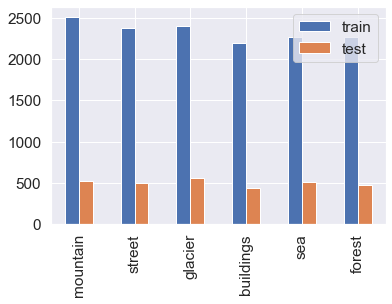

In [7]:
import pandas as pd

# _ is for ignoring the first output of the function
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

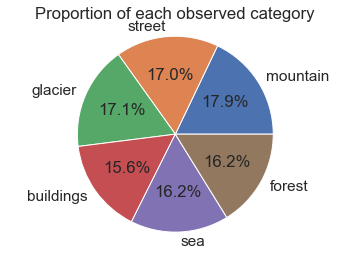

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Good practice: scale the data

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
We can display a random image from the training set.

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

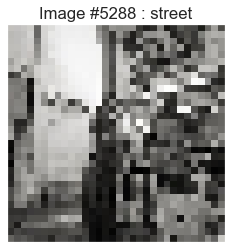

In [11]:
display_random_image(class_names, train_images, train_labels)

We can also display the first 25 images from the training set directly with a loop to get a better view

In [12]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

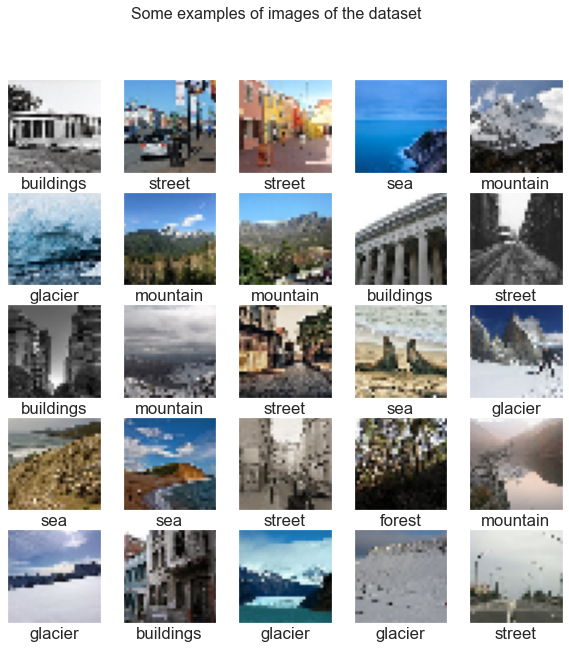

In [13]:
display_examples(class_names, train_images, train_labels)

# Beginner: Simple Model Creation

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [15]:
model.summary()
# convparams = filters * (in_chanels*kernel_h*kernel_w + 1) 1 del bias

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [27]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 6s 68ms/step - loss: 0.9347 - accuracy: 0.6511 - val_loss: 0.8523 - val_accuracy: 0.6751
Epoch 2/10
88/88 [==============================] - 6s 71ms/step - loss: 0.8558 - accuracy: 0.6880 - val_loss: 0.8633 - val_accuracy: 0.6694
Epoch 3/10
88/88 [==============================] - 6s 68ms/step - loss: 0.7831 - accuracy: 0.7123 - val_loss: 0.7805 - val_accuracy: 0.7157
Epoch 4/10
88/88 [==============================] - 6s 69ms/step - loss: 0.7380 - accuracy: 0.7344 - val_loss: 0.7249 - val_accuracy: 0.7428
Epoch 5/10
88/88 [==============================] - 6s 67ms/step - loss: 0.7082 - accuracy: 0.7386 - val_loss: 0.7389 - val_accuracy: 0.7339
Epoch 6/10
88/88 [==============================] - 6s 67ms/step - loss: 0.6755 - accuracy: 0.7530 - val_loss: 0.8084 - val_accuracy: 0.6936
Epoch 7/10
88/88 [==============================] - 6s 70ms/step - loss: 0.6471 - accuracy: 0.7630 - val_loss: 0.7186 - val_accuracy: 0.7428
Epoch 8/10
88

In [37]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

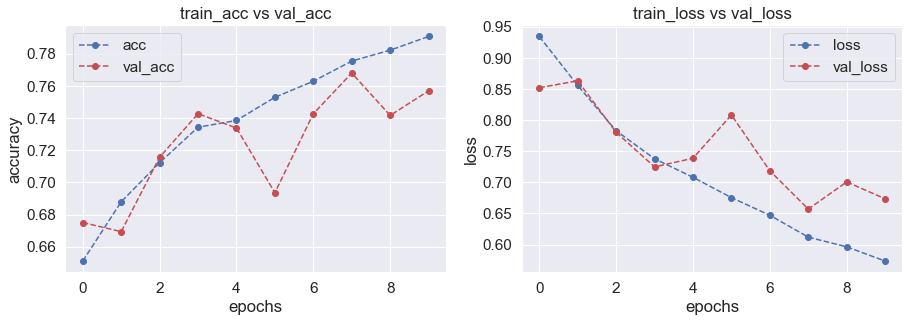

In [38]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [39]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.7517


In [40]:
test_loss

[0.6764287948608398, 0.7516666650772095]

We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

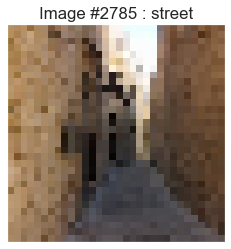

In [41]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [42]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


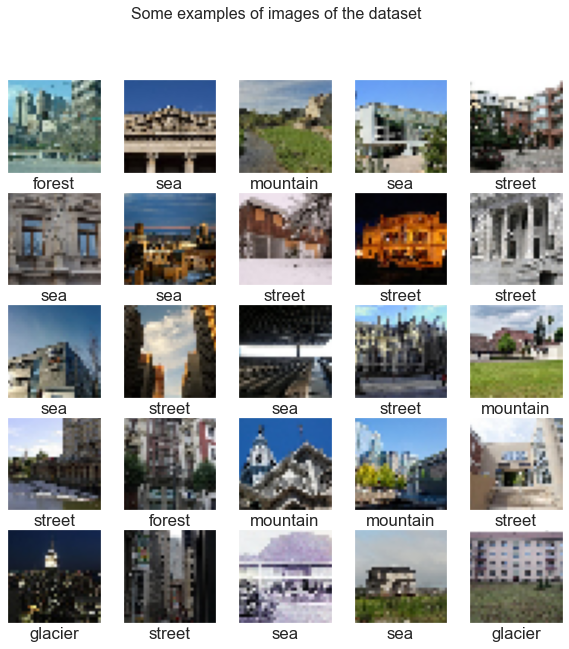

In [43]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

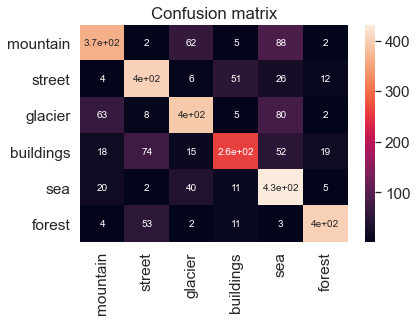

In [44]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()